In [118]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  GridSearchCV

# Time series decomposition
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'




In [119]:
#Read the dataset:
df=pd.read_csv("NSE-TATA.csv")
df['Date'] = pd.to_datetime(df['Date'], format = "%Y-%m-%d")
df.sort_values(by=["Date"], inplace=True, ignore_index=True)
df.head()
# print(df)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94
1,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
2,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
3,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
4,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09


In [120]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

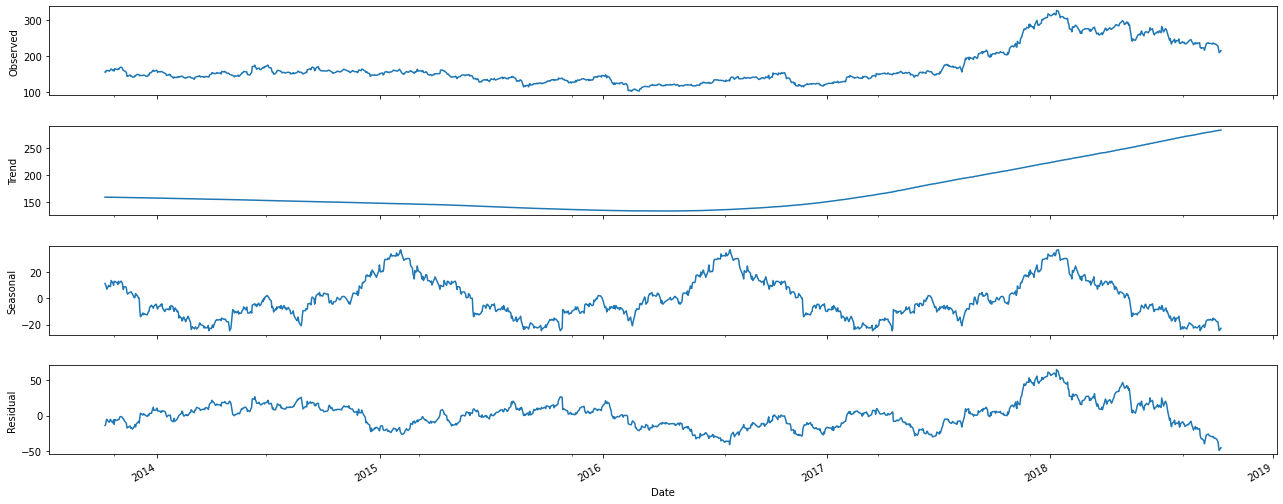

In [121]:
#Decomposition
df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

In [122]:
# Technical indicators

##Moving Averages
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

In [123]:
df

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),EMA_9,SMA_5,SMA_10,SMA_15,SMA_30
0,2013-10-08,157.00,157.80,155.20,155.80,155.80,1720413.0,2688.94,NaN,NaN,NaN,NaN,NaN
1,2013-10-09,155.70,158.20,154.15,155.30,155.55,2049580.0,3204.49,155.800000,NaN,NaN,NaN,NaN
2,2013-10-10,156.00,160.80,155.85,160.30,160.15,3124853.0,4978.80,155.668421,NaN,NaN,NaN,NaN
3,2013-10-11,161.15,163.45,159.00,159.80,160.05,1880046.0,3030.76,157.322140,NaN,NaN,NaN,NaN
4,2013-10-14,160.85,161.45,157.70,159.30,159.45,1281419.0,2039.09,158.115353,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05,232.580143,234.13,234.575,230.026667,232.683333
1231,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27,232.412129,233.65,234.270,230.683333,232.461667
1232,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79,231.930916,231.95,233.370,230.993333,232.070000
1233,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06,230.557824,228.74,231.685,230.740000,231.243333


In [124]:
#Relative Strength Index

def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

In [125]:
df

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI
0,2013-10-08,157.00,157.80,155.20,155.80,155.80,1720413.0,2688.94,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-10-09,155.70,158.20,154.15,155.30,155.55,2049580.0,3204.49,155.800000,NaN,NaN,NaN,NaN,0.000000
2,2013-10-10,156.00,160.80,155.85,160.30,160.15,3124853.0,4978.80,155.668421,NaN,NaN,NaN,NaN,0.000000
3,2013-10-11,161.15,163.45,159.00,159.80,160.05,1880046.0,3030.76,157.322140,NaN,NaN,NaN,NaN,0.000000
4,2013-10-14,160.85,161.45,157.70,159.30,159.45,1281419.0,2039.09,158.115353,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05,232.580143,234.13,234.575,230.026667,232.683333,59.974906
1231,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27,232.412129,233.65,234.270,230.683333,232.461667,56.635071
1232,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79,231.930916,231.95,233.370,230.993333,232.070000,52.412281
1233,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06,230.557824,228.74,231.685,230.740000,231.243333,35.974974


In [126]:
#MACD

EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [127]:
df

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2013-10-08,157.00,157.80,155.20,155.80,155.80,1720413.0,2688.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-10-09,155.70,158.20,154.15,155.30,155.55,2049580.0,3204.49,155.800000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,2013-10-10,156.00,160.80,155.85,160.30,160.15,3124853.0,4978.80,155.668421,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,2013-10-11,161.15,163.45,159.00,159.80,160.05,1880046.0,3030.76,157.322140,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,2013-10-14,160.85,161.45,157.70,159.30,159.45,1281419.0,2039.09,158.115353,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05,232.580143,234.13,234.575,230.026667,232.683333,59.974906,-0.625160,-1.492038
1231,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27,232.412129,233.65,234.270,230.683333,232.461667,56.635071,-0.967272,-1.387084
1232,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79,231.930916,231.95,233.370,230.993333,232.070000,52.412281,-1.974143,-1.504496
1233,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06,230.557824,228.74,231.685,230.740000,231.243333,35.974974,-3.458453,-1.895287


In [128]:
df['Close'] = df['Close'].shift(-1)
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

In [129]:
df

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2013-11-26,142.00,146.80,141.60,145.80,145.05,2505101.0,3641.28,151.254137,143.55,146.480,152.393333,157.383333,21.373057,-4.450313,-4.034456
1,2013-11-27,146.30,147.60,144.00,144.75,147.65,1855005.0,2699.14,150.662261,143.74,145.375,150.793333,156.898333,23.571429,-4.308106,-4.095769
2,2013-11-28,145.00,148.35,145.00,148.20,148.90,3615167.0,5318.02,150.086626,143.68,144.425,149.290000,156.418333,31.540698,-3.951744,-4.064257
3,2013-11-29,148.00,150.10,147.55,148.75,149.30,2020588.0,3005.77,149.837348,144.48,144.760,148.230000,156.071667,34.180791,-3.533063,-3.950179
4,2013-12-02,149.20,150.90,149.00,149.25,146.80,2063513.0,3091.19,149.741673,145.90,145.255,147.466667,155.635000,38.759690,-3.134499,-3.777553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,2018-09-28,234.05,235.95,230.20,233.50,230.90,3069914.0,7162.35,232.450159,234.30,233.465,229.270000,232.710000,66.323907,-0.515408,-1.708757
1197,2018-10-01,234.55,234.60,221.05,230.30,227.60,1534749.0,3486.05,232.580143,234.13,234.575,230.026667,232.683333,59.974906,-0.625160,-1.492038
1198,2018-10-03,230.00,237.50,225.75,226.45,218.20,1708590.0,3960.27,232.412129,233.65,234.270,230.683333,232.461667,56.635071,-0.967272,-1.387084
1199,2018-10-04,223.50,227.80,216.15,217.25,209.20,1728786.0,3815.79,231.930916,231.95,233.370,230.993333,232.070000,52.412281,-1.974143,-1.504496


In [130]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

In [131]:
train_df

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2013-11-26,142.00,146.80,141.60,145.80,145.05,2505101.0,3641.28,151.254137,143.55,146.480,152.393333,157.383333,21.373057,-4.450313,-4.034456
1,2013-11-27,146.30,147.60,144.00,144.75,147.65,1855005.0,2699.14,150.662261,143.74,145.375,150.793333,156.898333,23.571429,-4.308106,-4.095769
2,2013-11-28,145.00,148.35,145.00,148.20,148.90,3615167.0,5318.02,150.086626,143.68,144.425,149.290000,156.418333,31.540698,-3.951744,-4.064257
3,2013-11-29,148.00,150.10,147.55,148.75,149.30,2020588.0,3005.77,149.837348,144.48,144.760,148.230000,156.071667,34.180791,-3.533063,-3.950179
4,2013-12-02,149.20,150.90,149.00,149.25,146.80,2063513.0,3091.19,149.741673,145.90,145.255,147.466667,155.635000,38.759690,-3.134499,-3.777553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,2017-04-19,147.90,150.80,147.50,150.60,152.15,1092317.0,1632.17,149.336607,150.65,151.240,150.856667,147.320000,48.902821,1.837055,2.486633
837,2017-04-20,150.25,153.60,150.25,152.00,151.30,1540540.0,2346.43,149.422946,150.01,151.070,150.963333,147.548333,54.341737,1.857261,2.360759
838,2017-04-21,153.50,153.90,149.70,151.20,151.95,1293698.0,1966.07,149.695651,150.09,151.020,151.070000,147.845000,53.150685,1.784121,2.245431
839,2017-04-24,151.00,153.25,151.00,151.50,151.70,1079887.0,1642.96,149.856086,150.25,150.845,151.116667,148.130000,53.783784,1.758338,2.148013


In [132]:
valid_df

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
841,2017-04-26,152.45,156.60,151.60,154.05,152.10,4161713.0,6433.14,150.228930,151.46,151.055,151.313333,148.845000,52.941176,1.795186,2.005470
842,2017-04-27,155.00,155.40,151.55,152.00,153.10,1388038.0,2122.54,150.581037,152.17,151.090,151.436667,149.400000,47.619048,1.719124,1.948201
843,2017-04-28,153.40,154.70,152.00,152.80,157.70,1132516.0,1736.48,150.732933,152.16,151.125,151.400000,149.820000,56.756757,1.719713,1.902503
844,2017-05-02,154.30,161.45,153.75,157.50,156.20,6827849.0,10835.58,150.969640,152.52,151.385,151.403333,150.226667,64.835165,2.067527,1.935508
845,2017-05-03,158.85,158.85,155.55,156.25,155.35,1523044.0,2385.92,151.642676,153.67,152.210,151.876667,150.660000,56.422018,2.196812,1.987769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,2018-01-05,312.30,315.85,310.35,312.85,317.60,1896601.0,5938.16,300.477231,312.78,308.490,303.226667,293.165000,83.634021,11.381781,12.020700
1017,2018-01-08,314.65,319.20,312.20,317.45,315.30,2171903.0,6855.32,301.724508,312.09,309.770,305.136667,294.436667,83.903676,11.365418,11.889643
1018,2018-01-09,317.60,319.65,314.00,314.70,314.10,2411068.0,7628.80,303.312057,313.03,311.255,307.186667,295.733333,72.926448,11.039602,11.719635
1019,2018-01-10,315.00,319.10,312.55,314.25,313.30,2517494.0,7944.49,304.510852,313.86,312.190,308.816667,296.995000,70.106222,10.562799,11.488268


In [133]:
#Drop unnecessary columns
drop_cols = ['Date', 'Open', 'Low', 'High']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [134]:
train_df

,Last,Close,Total Trade Quantity,Turnover (Lacs),EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,145.80,145.05,2505101.0,3641.28,151.254137,143.55,146.480,152.393333,157.383333,21.373057,-4.450313,-4.034456
1,144.75,147.65,1855005.0,2699.14,150.662261,143.74,145.375,150.793333,156.898333,23.571429,-4.308106,-4.095769
2,148.20,148.90,3615167.0,5318.02,150.086626,143.68,144.425,149.290000,156.418333,31.540698,-3.951744,-4.064257
3,148.75,149.30,2020588.0,3005.77,149.837348,144.48,144.760,148.230000,156.071667,34.180791,-3.533063,-3.950179
4,149.25,146.80,2063513.0,3091.19,149.741673,145.90,145.255,147.466667,155.635000,38.759690,-3.134499,-3.777553
...,...,...,...,...,...,...,...,...,...,...,...,...
836,150.60,152.15,1092317.0,1632.17,149.336607,150.65,151.240,150.856667,147.320000,48.902821,1.837055,2.486633
837,152.00,151.30,1540540.0,2346.43,149.422946,150.01,151.070,150.963333,147.548333,54.341737,1.857261,2.360759
838,151.20,151.95,1293698.0,1966.07,149.695651,150.09,151.020,151.070000,147.845000,53.150685,1.784121,2.245431
839,151.50,151.70,1079887.0,1642.96,149.856086,150.25,150.845,151.116667,148.130000,53.783784,1.758338,2.148013


In [135]:
valid_df

,Last,Close,Total Trade Quantity,Turnover (Lacs),EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
841,154.05,152.10,4161713.0,6433.14,150.228930,151.46,151.055,151.313333,148.845000,52.941176,1.795186,2.005470
842,152.00,153.10,1388038.0,2122.54,150.581037,152.17,151.090,151.436667,149.400000,47.619048,1.719124,1.948201
843,152.80,157.70,1132516.0,1736.48,150.732933,152.16,151.125,151.400000,149.820000,56.756757,1.719713,1.902503
844,157.50,156.20,6827849.0,10835.58,150.969640,152.52,151.385,151.403333,150.226667,64.835165,2.067527,1.935508
845,156.25,155.35,1523044.0,2385.92,151.642676,153.67,152.210,151.876667,150.660000,56.422018,2.196812,1.987769
...,...,...,...,...,...,...,...,...,...,...,...,...
1016,312.85,317.60,1896601.0,5938.16,300.477231,312.78,308.490,303.226667,293.165000,83.634021,11.381781,12.020700
1017,317.45,315.30,2171903.0,6855.32,301.724508,312.09,309.770,305.136667,294.436667,83.903676,11.365418,11.889643
1018,314.70,314.10,2411068.0,7628.80,303.312057,313.03,311.255,307.186667,295.733333,72.926448,11.039602,11.719635
1019,314.25,313.30,2517494.0,7944.49,304.510852,313.86,312.190,308.816667,296.995000,70.106222,10.562799,11.488268


In [137]:
test_df

,Last,Close,Total Trade Quantity,Turnover (Lacs),EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
1021,325.95,323.00,14484043.0,46643.39,306.252790,314.65,313.715,310.543333,298.976667,76.806527,10.447201,11.042738
1022,323.70,316.40,4519030.0,14701.51,308.202511,317.21,314.650,312.250000,300.265000,70.082450,10.455190,10.925229
1023,317.60,313.55,4683847.0,14922.72,309.682260,318.29,315.660,313.600000,301.580000,61.151079,9.815807,10.703344
1024,314.05,305.45,3742677.0,11717.46,310.354034,318.51,316.185,314.296667,302.825000,56.888008,8.975654,10.357806
1025,304.50,308.35,3408593.0,10502.65,310.673630,318.40,316.420,314.830000,303.945000,38.769231,7.568974,9.800040
...,...,...,...,...,...,...,...,...,...,...,...,...
1196,233.50,230.90,3069914.0,7162.35,232.450159,234.30,233.465,229.270000,232.710000,66.323907,-0.515408,-1.708757
1197,230.30,227.60,1534749.0,3486.05,232.580143,234.13,234.575,230.026667,232.683333,59.974906,-0.625160,-1.492038
1198,226.45,218.20,1708590.0,3960.27,232.412129,233.65,234.270,230.683333,232.461667,56.635071,-0.967272,-1.387084
1199,217.25,209.20,1728786.0,3815.79,231.930916,231.95,233.370,230.993333,232.070000,52.412281,-1.974143,-1.504496


In [136]:
#Split into features and labels
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)
# X_train = train_df.drop(['Stock'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)
# X_valid = valid_df.drop(['Stock'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Last                  841 non-null    float64
 1   Total Trade Quantity  841 non-null    float64
 2   Turnover (Lacs)       841 non-null    float64
 3   EMA_9                 841 non-null    float64
 4   SMA_5                 841 non-null    float64
 5   SMA_10                841 non-null    float64
 6   SMA_15                841 non-null    float64
 7   SMA_30                841 non-null    float64
 8   RSI                   841 non-null    float64
 9   MACD                  841 non-null    float64
 10  MACD_signal           841 non-null    float64
dtypes: float64(11)
memory usage: 72.4 KB


In [138]:
X_test

,Last,Total Trade Quantity,Turnover (Lacs),EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
1021,325.95,14484043.0,46643.39,306.252790,314.65,313.715,310.543333,298.976667,76.806527,10.447201,11.042738
1022,323.70,4519030.0,14701.51,308.202511,317.21,314.650,312.250000,300.265000,70.082450,10.455190,10.925229
1023,317.60,4683847.0,14922.72,309.682260,318.29,315.660,313.600000,301.580000,61.151079,9.815807,10.703344
1024,314.05,3742677.0,11717.46,310.354034,318.51,316.185,314.296667,302.825000,56.888008,8.975654,10.357806
1025,304.50,3408593.0,10502.65,310.673630,318.40,316.420,314.830000,303.945000,38.769231,7.568974,9.800040
...,...,...,...,...,...,...,...,...,...,...,...
1196,233.50,3069914.0,7162.35,232.450159,234.30,233.465,229.270000,232.710000,66.323907,-0.515408,-1.708757
1197,230.30,1534749.0,3486.05,232.580143,234.13,234.575,230.026667,232.683333,59.974906,-0.625160,-1.492038
1198,226.45,1708590.0,3960.27,232.412129,233.65,234.270,230.683333,232.461667,56.635071,-0.967272,-1.387084
1199,217.25,1728786.0,3815.79,231.930916,231.95,233.370,230.993333,232.070000,52.412281,-1.974143,-1.504496


In [139]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

[09:15:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:15:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:15:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some par

In [ ]:
parameters2 = {
    'n_estimators': [400],
    'learning_rate': [0.05],
    'max_depth': [12],
    'gamma': [0.01],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters2)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

In [ ]:
# %%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

In [ ]:
plot_importance(model)

In [ ]:
X_test

In [ ]:
y_test

In [ ]:
#Calculate and visualize predictions
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

In [ ]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

In [ ]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

In [ ]:
import utils as u
u.save_model(clf,'XGBoost.txt')

In [ ]:
import utils as u
#load & test
eval_set = [(X_train, y_train), (X_valid, y_valid)]
clf2 = u.load_model('XGBoost.txt')
print("params: ", clf2.best_params_)
model2 = xgb.XGBRegressor(**clf2.best_params_, objective='reg:squarederror')
model2.fit(X_train, y_train, eval_set=eval_set, verbose=False)
## Calculate and visualize predictions
y_pred2 = model2.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred2[:5]}')

print(f'mean_squared_error = {mean_squared_error(y_test, y_pred2)}')
